# Householder reflections and the Householder QR algorithm

IAM 961 Numerical Linear Algebra, University of New Hampshire, J. Gibson, 2025-09-30.

This notebook demos the geometric construction of Householder reflections and
shows they are applied iteratively how in the Householder algorithm for QR 
decomposition. The QR decomposition of an $m \times m$ matrix $A$ is a factorization of form
\begin{align*}
A = QR
\end{align*}
where $Q$ is unitary and $R$ is upper triangular. The Householder algorithm
computes this factorization through a sequence of unitary Householder reflections
\begin{align*}
Q_{m-1} \, Q_{m-2} \ldots Q_2 \, Q_1 \, A = R
\end{align*}
Each $Q_j$ is a Householder reflector that acts on $Q_{j-1} \ldots Q_1 A$ and 
zeros the subdiagonal elements of its $j$th column.


In [1]:
using LinearAlgebra, Plots  
include("plotutils.jl")     # define some handy plotting functions

plotpoint (generic function with 2 methods)

## Visualization of a Householder reflection

Begin with a random $4 \times 4$ matrix $A$.

In [2]:
m = 4
A = randn(m,m)

4×4 Matrix{Float64}:
 -0.387375   0.790685  -0.656259    0.0707751
  0.124751  -0.384307  -1.78549     0.394932
 -0.168079  -0.682201  -0.918981    0.688947
  1.52858    1.38095    0.0811324  -1.58658

## First iteration of the Householder algorithm

For the first iteration, we construct a Householder reflection matrix $Q_1$ that zeros
the subdiagonal elements of the first column of $A$. Below we illustrate this construction
in several steps.

To make plots, we need to project vectors in $\mathbb{R}^4$ onto $\mathbb{R}^2$. The
whole construction takes place in the plane spanned by $e_1 = (1,0,0,0)^*$ and the first
column of $A$. So let $x$ be the first column of $A$, construct a unit vector $e_x$ orthogonal
to $e_1$ in the $e_1, x$ plane, and project vectors from $\mathbb{R}^4$ to the plane
using the $4 \times 2$ matrix $P_{\text{view}} = [e_1 \; e_x]^*$. 

Our first plot is of $e_1$, $e_x$, and $x$ projected onto the $e_1, e_x$ plane.

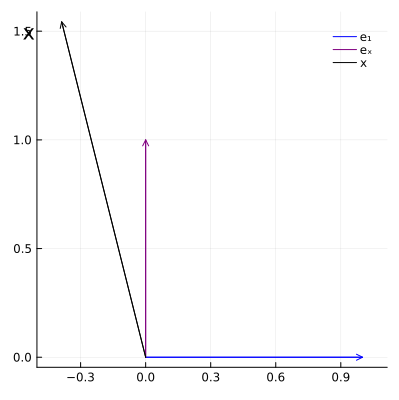

In [3]:
x = A[:,1]
e1 = [1; zeros(m-1)]
ex = (I - e1*e1')x           # vector in e1, x plane orthog to e1
ex = sign(ex[2])*ex/norm(ex) # normalize ex, make it point up

Pview = [e1'; ex']           # matrix to project R^m onto e1,ex plane
θ = 0.1; 
R = [cos(θ) -sin(θ); sin(θ) cos(θ)] # matrix to rotate labels away from vectors

plotvector(Pview*e1, "e₁", :blue)
plotvector!(Pview*ex, "eₓ", :purple)
plotvector!(Pview*x, "x", :black)
annotate!([(R*Pview*x)[1]], [(R*Pview*x)[2]], "x")
plot!(legend=:topright, foreground_color_legend = nothing, background_color_legend=nothing)
p1 = plot!()

The first Householder reflection matrix $Q_1$ should map $x$ to 
$\pm \|x\|_2 \, e_1$, whichever is further from $x$. This is done 
by chosing $-\text{sgn}(x_1) \|x\|_2 \, e_1$, where $x_1$ is the 1st
coordinate of $x$ and $\text{sgn}(\xi) = -1$ for   $\xi < 0$ and 1 for $\xi \geq 0$.

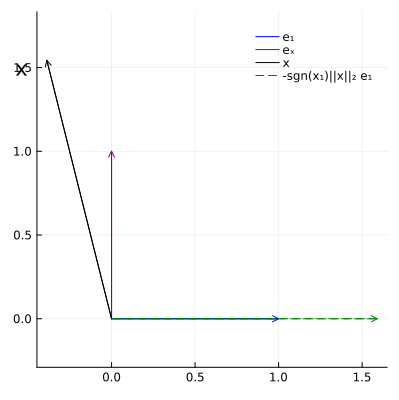

In [4]:
sgn(x) = x<0 ? -1 : 1 # C style ternary operator ? 

sgn_xnorm_e1 = -sgn(x[1])*norm(x)*e1

plot(p1)
plotvector!(Pview*sgn_xnorm_e1, "-sgn(x₁)||x||₂ e₁", :green, :dash)
#plot!(legend=:topleft)
p2 = plot!()

Now we compute the vector from $-\text{sgn}(x_1) \|x\|_2 \, e_1$ to $x$
and normalize it to get a unit vector $q$ in the same direction.

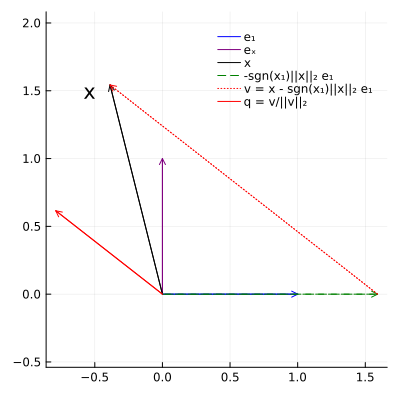

In [5]:
v = x - sgn_xnorm_e1
q = v/norm(v)

plot(p2)
plotvector!(Pview*v, "v = x - sgn(x₁)||x||₂ e₁", :red, :dot, Pview*sgn_xnorm_e1)
plotvector!(Pview*q, "q = v/||v||₂", :red)
plot!(legend=:topright)
p3 = plot!()

The unit vector $q$ then defines the Householder reflector matrix $F = I - 2q q^*$.
This matrix reflects $R^4$ through the hyperplane orthogonal to $q$. The dashed line 
in the plot below shows the projection of this hyperplane onto the $e_1, e_x$ plane.

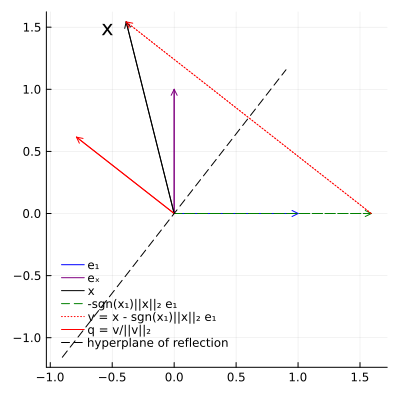

In [6]:
Porthoq = I - q*q'
F = I - 2q*q'

plot(p3)
plotline!(-1.5*Pview*Porthoq*x, 1.5*Pview*Porthoq*x, "hyperplane of reflection", :black, :dash)
annotate!(1.2*[(Pview*F*x)[1]], 1.2*[(Pview*F*x)[2]], "Fx")
plot!(legend=:bottomleft, foreground_color_legend = nothing, background_color_legend=nothing)

#ℓ = 2; plot!(xlim=(-ℓ,ℓ), ylim=(-ℓ,ℓ))
p4 = plot!()

Examine F...

In [7]:
F

4×4 Matrix{Float64}:
 -0.24352     0.0784238   -0.105662     0.960928
  0.0784238   0.995054     0.00666364  -0.0606019
 -0.105662    0.00666364   0.991022     0.0816498
  0.960928   -0.0606019    0.0816498    0.257444

Show $F$ is unitary...

In [8]:
norm(F'*F-I)

3.7157453180488975e-16

For the 1st iteration of the algorithm ($j=1$), $Q_1 = F$. Apply $Q_1$ to $A$ and see
that it zeros the subdiagonal elements in the 1st column.

In [9]:
Q₁ = F
Q₁A = Q₁*A

4×4 Matrix{Float64}:
  1.59073       1.17639    0.194851  -1.58365
 -1.01692e-17  -0.408632  -1.83917    0.49927
  6.39825e-18  -0.649428  -0.846663   0.548371
 -1.0606e-16    1.0829    -0.576562  -0.308127

## Second iteration of Householder algorithm

In the second iteration of the algorithm, we construct a unitary $Q_2$ that zeros 
the subdiagonal elements of the second column of $Q_1 A$. The matrix $Q_2$ has the 
form
\begin{align*}
Q_2 = \left[ \begin{array}{c|c c c c c} 1 & & & \\ \hline  \\  & & F & \\ \\ \end{array} \right]
\end{align*}
where $F$ is an $3 \times 3$ unitary matrix that acts on lower-right $3 \times 3$
submatrix of $Q_1 A$. Let $\hat{A}$ represent this submatrix of $Q_1 A$. Then the
second iteration proceeds very nearly the same as the first iteration, with some changes
in dimensions and indexing.

In [10]:
Â = Q₁A[2:m, 2:m] # get rows 2 through m, cols 2 through m of Â
x = Â[:,1]
sgn_xnorm_e1 = [-sign(x[1])*norm(x); zeros(m-2)]
v = x - sgn_xnorm_e1
q = v/norm(v)

F = I - 2q*q'
Q₂ = diagm(ones(m))
Q₂[2:end, 2:end] = F
Q₂

4×4 Matrix{Float64}:
 1.0   0.0        0.0       0.0
 0.0  -0.307895  -0.489329  0.815939
 0.0  -0.489329   0.816925  0.305271
 0.0   0.815939   0.305271  0.490971

In [11]:
Q₂Q₁A = Q₂*Q₁A

4×4 Matrix{Float64}:
  1.59073       1.17639       0.194851   -1.58365
 -8.65382e-17   1.32718       0.510129   -0.67347
 -2.2174e-17   -5.35001e-17   0.0322909   0.109608
 -5.84165e-17   2.3223e-16   -2.04219     0.423495

## Third and last iteration

In [12]:
Â = Q₂Q₁A[3:m, 3:m]
x = Â[:,1]
sgn_xnorm_e1 = [-sign(x[1])*norm(x); zeros(m-3)]
v = x - sgn_xnorm_e1
q = v/norm(v)

F = I - 2q*q'
Q₃ = diagm(ones(m))
Q₃[3:end, 3:end] = F
Q₃

4×4 Matrix{Float64}:
 1.0  0.0   0.0        0.0
 0.0  1.0   0.0        0.0
 0.0  0.0  -0.0158099  0.999875
 0.0  0.0   0.999875   0.0158099

In [13]:
R = Q₃*Q₂Q₁A

4×4 Matrix{Float64}:
  1.59073       1.17639       0.194851     -1.58365
 -8.65382e-17   1.32718       0.510129     -0.67347
 -5.80587e-17   2.33047e-16  -2.04244       0.421709
 -2.30948e-17  -4.98219e-17  -5.70362e-17   0.11629

In [14]:
Q = (Q₃*Q₂*Q₁)'

4×4 adjoint(::Matrix{Float64}) with eltype Float64:
 -0.24352     0.811616  0.500792    0.176591
  0.0784238  -0.359081  0.791991   -0.487505
 -0.105662   -0.420367  0.33487     0.836654
  0.960928    0.188764  0.0990967   0.176535

In [15]:
Q*R

4×4 Matrix{Float64}:
 -0.387375   0.790685  -0.656259    0.0707751
  0.124751  -0.384307  -1.78549     0.394932
 -0.168079  -0.682201  -0.918981    0.688947
  1.52858    1.38095    0.0811324  -1.58658

In [16]:
A

4×4 Matrix{Float64}:
 -0.387375   0.790685  -0.656259    0.0707751
  0.124751  -0.384307  -1.78549     0.394932
 -0.168079  -0.682201  -0.918981    0.688947
  1.52858    1.38095    0.0811324  -1.58658

In [17]:
norm(A - Q*R)

2.1871499253295408e-15

In [18]:
norm(Q'*Q-I)

1.051302160137936e-15

## Solve an Ax=b problem

We'll need a backsubsitution algorithm to solve $Rx = \hat{b} = Q^*b$. The formula is

\begin{align*}
  x_i = \frac{1}{r_{ii}}\left(\hat{b}_i - \sum_{j=i+1}^m r_{ij} x_j\right)
\end{align*}

In [19]:
"""
solve upper-triangular system Rx=b using backsubstitution
"""
function backsub(R,b)
    m = length(b)
    m_, n_ = size(R)
    if m_ ≠ m || n_ ≠ m
        error("R is $m_ x $n_, but b is length $m") # string interpolation
    end

    x = zeros(m)
    for i = m:-1:1  # sequence of integers m, m-1, m2, ..., 2, 1
        s = b[i]
        for j = i+1:m
            s -= R[i,j]*x[j]   # s -= c means s = s - c
        end
        x[i] = s/R[i,i]
    end
    x       # return val of function is value of last statement executed
end

backsub

In [20]:
m,n = size(A)

(4, 4)

In [21]:
3 in 1:6

true

In [22]:
x = randn(m)
b = A*x

x

4-element Vector{Float64}:
  0.855365993367399
 -1.794816544131191
 -0.057658866221542336
 -1.4491609049504783

In [23]:
x̂ = backsub(R, Q'*b)

4-element Vector{Float64}:
  0.8553659933673982
 -1.7948165441311914
 -0.05765886622154239
 -1.4491609049504799

## Upcoming HW problem: 

Write three functions that perform QR decomposition usig CGS, MGS, and Householder algorithms.